In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import random
import seaborn as sns
pd.options.display.max_rows=300
pd.set_option('display.max_columns', None)

# MIMIC 

In [2]:
df_type = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/01.MIMICIV_SAKI_trajCluster/df_mixAK_fea4_C3.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("纳入患者数量：",len(all_lst))

df_type_filt["groupHPD"].value_counts()

纳入患者数量： 4713


2    3055
1    1298
3     360
Name: groupHPD, dtype: int64

In [3]:
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_event_time.csv")
df_time = df_time[["stay_id","saki_onset"]]
df_time["saki_onset"] = pd.to_datetime(df_time["saki_onset"])                                               
# df_time["saki_onset_a1d"] = df_time["saki_onset"] + dt.timedelta(hours=24)
df_time.head(2)

,stay_id,saki_onset
0,30024511,2176-08-21 04:00:00
1,30024934,2143-05-02 08:27:00


In [4]:
df_stage =  pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/kdigo_stages.csv")
df_stage = pd.merge(df_stage,df_type_filt,how="inner",on="stay_id") #[df_stage["stay_id"].isin(all_lst)]
df_stage["charttime"] = pd.to_datetime(df_stage["charttime"], format='%d/%m/%Y %H:%M:%S')
df_stage = pd.merge(df_stage,df_time,how="inner",on="stay_id")
df_stage = df_stage[(df_stage["charttime"] >= df_stage["saki_onset"])] #(df_stage["charttime"] <= df_stage["saki_onset_a1d"]) & 
df_stage = df_stage[["stay_id","aki_stage_uo","aki_stage","aki_stage_creat","groupHPD"]]
df_stage = df_stage.groupby(["stay_id"]).agg({"aki_stage_uo":"max","aki_stage_creat":"max","groupHPD":"mean"}).reset_index()
df_stage = df_stage.fillna(0)
df_stage.columns = ["stay_id","aki_stage_uo_max","aki_stage_creat_max","groupHPD"]
df_stage.head(1)

,stay_id,aki_stage_uo_max,aki_stage_creat_max,groupHPD
0,30003598,3.0,1.0,1.0


In [5]:
df_bt_at = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/06.fluid_resuscitation/01.mimic/df_diuretic_responsitive.csv")
df_bt_at = df_bt_at[["stay_id","label_diu_res"]]
df_stage = pd.merge(df_stage, df_bt_at,how="left", on = "stay_id")
df_stage

,stay_id,aki_stage_uo_max,aki_stage_creat_max,groupHPD,label_diu_res
0,30003598,3.0,1.0,1.0,responsive
1,30004144,3.0,0.0,2.0,responsive
2,30005085,2.0,0.0,2.0,responsive
3,30006983,3.0,3.0,2.0,responsive
4,30008148,2.0,0.0,2.0,responsive
...,...,...,...,...,...
4708,39985287,2.0,1.0,1.0,responsive
4709,39989733,2.0,2.0,1.0,responsive
4710,39992167,2.0,0.0,2.0,responsive
4711,39993683,3.0,0.0,1.0,responsive


<ipython-input-6-576761c03565>:42: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(legend_labels, bbox_to_anchor=(0.8, -0.15), ncol=6, loc='lower center', fontsize=12,


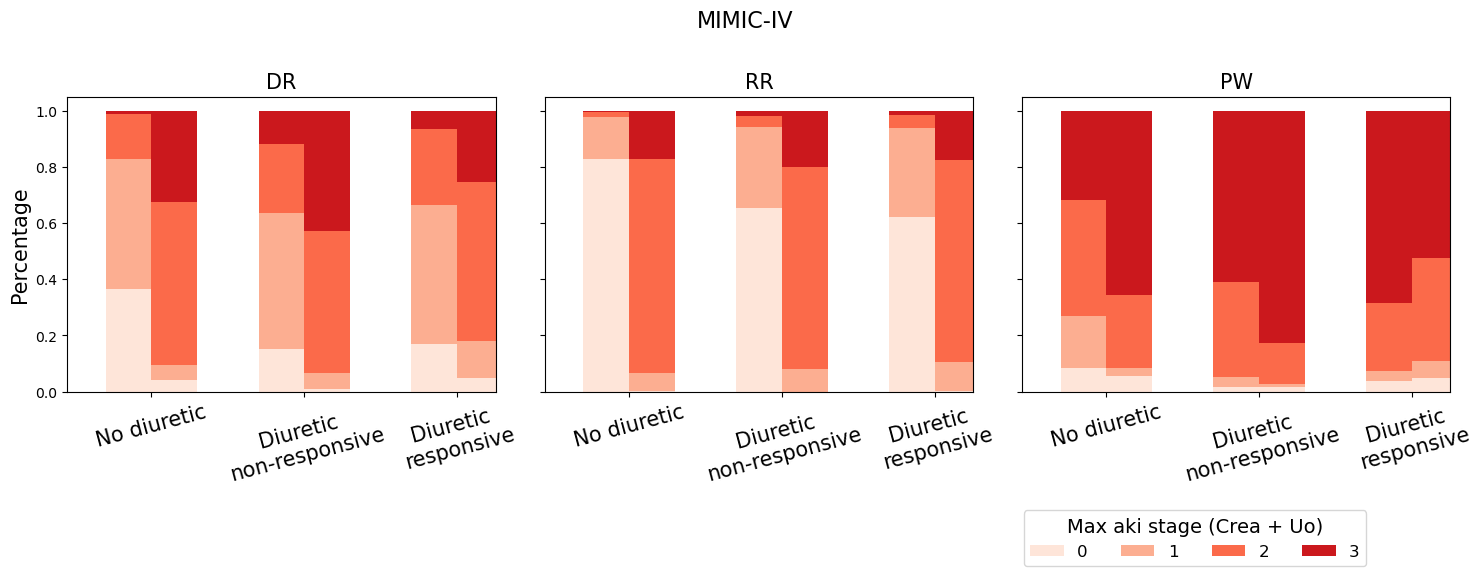

In [6]:
df = df_stage
grouped_df = df.groupby('groupHPD')

# 创建子图
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
map_dict = {1:"DR",2:"RR",3:"PW"}
colors_uo = ['#fee5d9', '#fcae91', '#fb6a4a',"#cb181d"]  # Customize these colors as needed
colors_creat = ['#fee5d9', '#fcae91', '#fb6a4a',"#cb181d"]  # Customize these colors as needed

# 循环绘制每个子图
for i, (group, data_group) in enumerate(grouped_df):
    ax = axes[i]
    
    # 计算占比
    total_counts = data_group['label_diu_res'].count()
    
    # 处理数据并绘制堆叠图
    data_group['count'] = 1
    stacked_df_uo = data_group.pivot_table(index='label_diu_res', columns='aki_stage_uo_max', values='count', aggfunc='sum', fill_value=0)
    stacked_df_creat = data_group.pivot_table(index='label_diu_res', columns='aki_stage_creat_max', values='count', aggfunc='sum', fill_value=0)
    
    # 绘制堆叠图
    stacked_df_uo.div(stacked_df_uo.sum(1), axis=0).plot(kind='bar', stacked=True, ax=ax, 
                                                         rot=0, position=0,width=0.3
                                                        ,color=colors_uo)
    stacked_df_creat.div(stacked_df_creat.sum(1), axis=0).plot(kind='bar', stacked=True, ax=ax,
                                                               rot=0, position=1,width=0.3
                                                              ,color=colors_creat)
    
    # 添加标签
    custom_xtick_labels = ['No diuretic', 'Diuretic \nnon-responsive', 'Diuretic \nresponsive']  # Customize these labels as needed
    ax.set_xticklabels(custom_xtick_labels, rotation=15,size=15)
    ax.set_xlabel('')
    ax.set_ylabel('Percentage',size=15)
    ax.set_title(map_dict[int(group)], fontsize=15)
    ax.legend().set_visible(False)
fig.suptitle('MIMIC-IV', fontsize=16)

legend_labels = ['Max uo aki_stage'] #, 'Max crea aki_stage'
legend_colors = colors_uo + colors_creat
labels = [0,1,2,3] # ,0,1
fig.legend(legend_labels, bbox_to_anchor=(0.8, -0.15), ncol=6, loc='lower center', fontsize=12,
           title='Max aki stage (Crea + Uo)', title_fontsize=14, labels=labels)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect parameter to make room for the suptitle
plt.show()


# AUMC

In [7]:
df_type = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/02.AUMCdb_SAKI_trajCluster/df_mixAK_fea3_C3_aumc.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("纳入患者数量：",len(all_lst))

df_type_filt["groupHPD"].value_counts()

纳入患者数量： 2183


2    1400
1     564
3     219
Name: groupHPD, dtype: int64

In [8]:
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/disease_definition/AKI/aumcdb_sk_event_time.csv")
df_time = df_time[["stay_id","saki_onset"]]
# df_time["saki_onset_a1d"] = df_time["saki_onset"] + 24
df_time.head(2)

,stay_id,saki_onset
0,0,NaN
1,1,NaN


In [9]:
df_stage =  pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc//disease_definition/AKI/kdigo_aki_stage.csv")
df_stage = df_stage.rename(columns={"admissionid":"stay_id"})
df_stage = pd.merge(df_stage,df_type_filt,how="inner",on="stay_id") #[df_stage["stay_id"].isin(all_lst)]
df_stage = pd.merge(df_stage,df_time,how="inner",on="stay_id")
df_stage = df_stage[df_stage["time"] >= df_stage["saki_onset"]] #(df_stage["time"] <= df_stage["saki_onset_a1d"]) & (
df_stage = df_stage[["stay_id","aki_stage_uo","aki_stage","aki_stage_creat","groupHPD"]]
df_stage = df_stage.groupby(["stay_id"]).agg({"aki_stage_uo":"max","aki_stage_creat":"max","groupHPD":"mean"}).reset_index()
df_stage = df_stage.fillna(0)
df_stage.columns = ["stay_id","aki_stage_uo_max","aki_stage_creat_max","groupHPD"]
df_stage.head(1)

,stay_id,aki_stage_uo_max,aki_stage_creat_max,groupHPD
0,5,3.0,0.0,2.0


In [10]:
df_bt_at = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/06.fluid_resuscitation/02.aumc/df_diuretic_responsitive.csv")
df_bt_at = df_bt_at[["stay_id","label_diu_res"]]
df_stage = pd.merge(df_stage, df_bt_at,how="left", on = "stay_id")
df_stage

,stay_id,aki_stage_uo_max,aki_stage_creat_max,groupHPD,label_diu_res
0,5,3.0,0.0,2.0,responsive
1,15,3.0,1.0,2.0,responsive
2,20,2.0,0.0,2.0,No diuretic
3,35,3.0,0.0,2.0,responsive
4,38,2.0,0.0,2.0,responsive
...,...,...,...,...,...
2178,23464,3.0,1.0,2.0,responsive
2179,23484,2.0,0.0,2.0,responsive
2180,23485,2.0,0.0,2.0,No diuretic
2181,23488,3.0,1.0,1.0,No diuretic


<ipython-input-11-1c2b258f1e0c>:42: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(legend_labels, bbox_to_anchor=(0.8, -0.15), ncol=6, loc='lower center', fontsize=12,


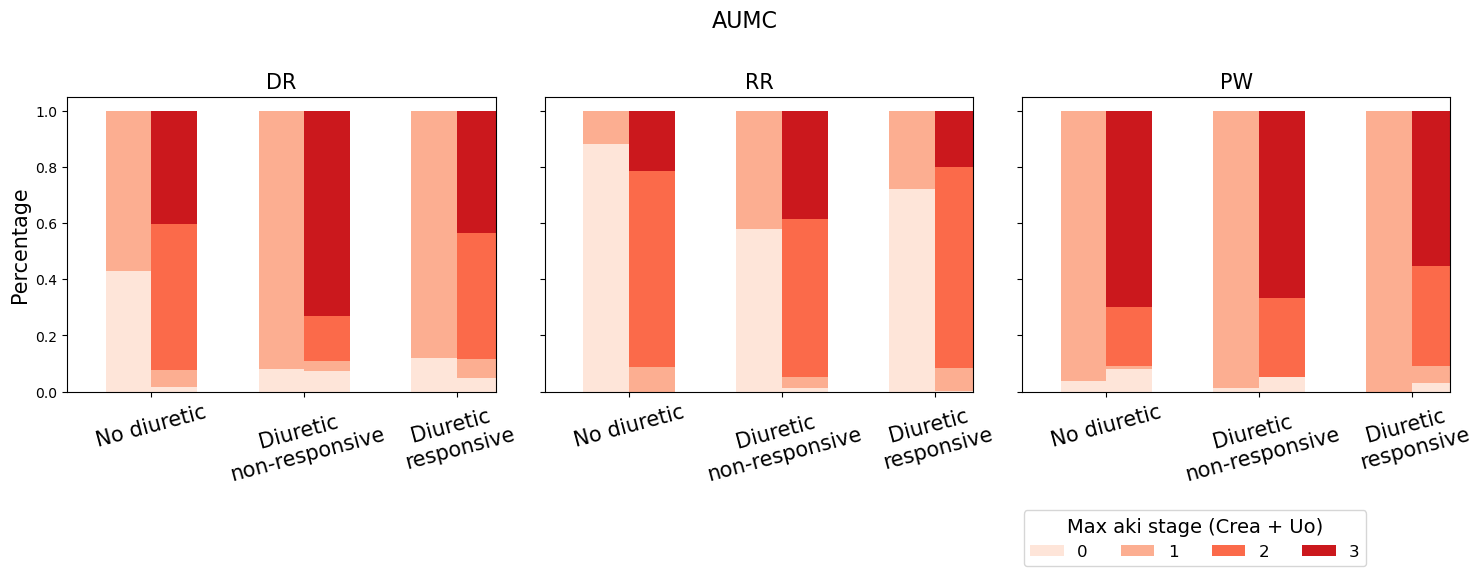

In [11]:
df = df_stage
grouped_df = df.groupby('groupHPD')

# 创建子图
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
map_dict = {1:"DR",2:"RR",3:"PW"}
colors_uo = ['#fee5d9', '#fcae91', '#fb6a4a',"#cb181d"]  # Customize these colors as needed
colors_creat = ['#fee5d9', '#fcae91']  # Customize these colors as needed

# 循环绘制每个子图
for i, (group, data_group) in enumerate(grouped_df):
    ax = axes[i]
    
    # 计算占比
    total_counts = data_group['label_diu_res'].count()
    
    # 处理数据并绘制堆叠图
    data_group['count'] = 1
    stacked_df_uo = data_group.pivot_table(index='label_diu_res', columns='aki_stage_uo_max', values='count', aggfunc='sum', fill_value=0)
    stacked_df_creat = data_group.pivot_table(index='label_diu_res', columns='aki_stage_creat_max', values='count', aggfunc='sum', fill_value=0)
    
    # 绘制堆叠图
    stacked_df_uo.div(stacked_df_uo.sum(1), axis=0).plot(kind='bar', stacked=True, ax=ax, 
                                                         rot=0, position=0,width=0.3
                                                        ,color=colors_uo)
    stacked_df_creat.div(stacked_df_creat.sum(1), axis=0).plot(kind='bar', stacked=True, ax=ax,
                                                               rot=0, position=1,width=0.3
                                                              ,color=colors_creat)
    
    # 添加标签
    custom_xtick_labels = ['No diuretic', 'Diuretic \nnon-responsive', 'Diuretic \nresponsive']  # Customize these labels as needed
    ax.set_xticklabels(custom_xtick_labels, rotation=15,size=15)
    ax.set_xlabel('')
    ax.set_ylabel('Percentage',size=15)
    ax.set_title(map_dict[int(group)], fontsize=15)
    ax.legend().set_visible(False)
fig.suptitle('AUMC', fontsize=16)

legend_labels = ['Max uo aki_stage'] #, 'Max crea aki_stage'
legend_colors = colors_uo + colors_creat
labels = [0,1,2,3] # ,0,1
fig.legend(legend_labels, bbox_to_anchor=(0.8, -0.15), ncol=6, loc='lower center', fontsize=12,
           title='Max aki stage (Crea + Uo)', title_fontsize=14, labels=labels)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect parameter to make room for the suptitle
plt.show()
